In [61]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt

In [62]:
fp = "/Users/Ben/Work/NCEM/Projects/4D-DataViewer/sample_data/20180905/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read_data(fp)

Reading file /Users/Ben/Work/NCEM/Projects/4D-DataViewer/sample_data/20180905/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5...

/Users/Ben/Work/NCEM/Projects/4D-DataViewer/sample_data/20180905/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM HDF5 file.  Reading...


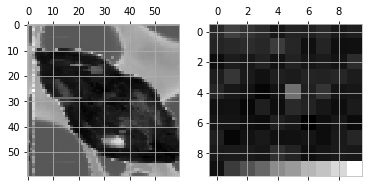

In [65]:
# ROI

xmin,xmax=45,55
ymin,ymax=7,17

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
ax2.matshow(np.average(dc.data4D,axis=(2,3))[xmin:xmax,ymin:ymax,],cmap='gray')
plt.show()

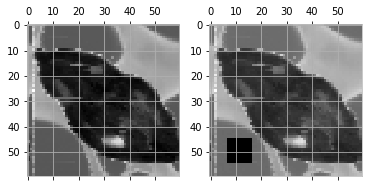

In [66]:
fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(np.average(dc.data4D,axis=(2,3)),cmap='gray')
im = np.average(dc.data4D,axis=(2,3))
im[xmin:xmax,ymin:ymax] = 0
ax2.matshow(im,cmap='gray')
plt.show()

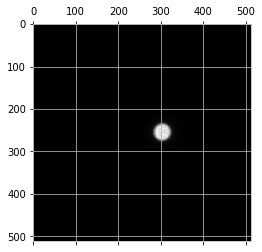

In [67]:
# Average DP, unshifted

DP_ave_unshifted = np.average(dc.data4D[xmin:xmax,ymin:ymax],axis=(0,1))

fig,ax=plt.subplots()
ax.matshow(DP_ave_unshifted,cmap='gray')
plt.show()

In [68]:
def get_shift(im1,im2):
    cc = np.fft.ifft2(np.fft.fft2(im1)*np.conj(np.fft.fft2(im2)))
    xshift,yshift = np.unravel_index(np.argmax(cc),dc.data4D.shape[2:4])
    return xshift,yshift

def get_shifted_im(im,xshift,yshift):
    nx,ny = np.shape(im)
    rxT,ryT = np.meshgrid(np.arange(nx),np.arange(ny))
    rx,ry = rxT.T,ryT.T
    nx,ny = float(nx),float(ny)
    
    w = -np.exp(-(2j*np.pi)*( (xshift*rx)/nx + (yshift*ry)/ny ))
    shifted_im = np.abs(np.fft.ifft2(np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(im))*w)))
    return shifted_im

In [69]:
# Get average shifted diffraction pattern

ref_DP = dc.data4D[xmin,ymin,:,:]

for n in range(1,(xmax-xmin)*(ymax-ymin)):
    i = xmin + n%(xmax-xmin)
    j = ymin + int(n/(xmax-xmin))
    curr_DP = dc.data4D[i,j,:,:]
    
    xshift,yshift = get_shift(ref_DP, curr_DP)
    curr_DP_shifted = get_shifted_im(curr_DP,xshift,yshift)
    ref_DP = ref_DP*(n-1)/n + curr_DP_shifted/n

In [77]:
def get_CoM(im):
    nx,ny=np.shape(im)
    rx,ry = np.meshgrid(np.arange(nx),np.arange(ny))
    tot_intens = np.sum(im)
    xCoM = np.sum(rx*im)/tot_intens
    yCoM = np.sum(ry*im)/tot_intens
    return xCoM,yCoM

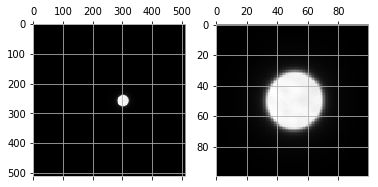

In [79]:
# Get center of mass
# Show shifted, averaged DP

xCoM,yCoM = get_CoM(ref_DP)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP,cmap='gray')
ax2.matshow(ref_DP[int(yCoM)-50:int(yCoM)+50,int(xCoM)-50:int(xCoM)+50])
plt.show()

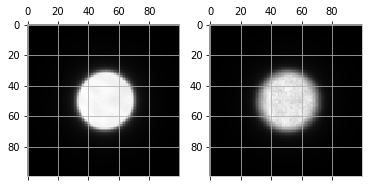

In [80]:
# Compare shifted to unshifted ave DPs

xCoM_unshifted,yCoM_unshifted = get_CoM(DP_ave_unshifted)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(ref_DP[int(yCoM)-50:int(yCoM)+50,int(xCoM)-50:int(xCoM)+50])
ax2.matshow(DP_ave_unshifted[int(yCoM_unshifted)-50:int(yCoM_unshifted)+50,int(xCoM_unshifted)-50:int(xCoM_unshifted)+50])
plt.show()

In [ ]:
rx,ry = np.meshgrid(np.arange(nx),np.arange(ny))
tot_intens = np.sum(im)
xCoM = np.sum(rx*im)/tot_intens
yCoM = np.sum(ry*im)/tot_intens
return xCoM,yCoM

In [ ]:
% find center and size of probe
[ya,xa] = meshgrid(1:sNBED.stackSize(2),1:sNBED.stackSize(1));
maskRound = sNBED.templateInit > (max(sNBED.templateInit(:)) * threshProbe);
mask = bwmorph(maskRound,'dilate',expandProbe);
intTotal = sum(sNBED.templateInit(mask));
xProbe = sum(xa(mask) .* sNBED.templateInit(mask)) / intTotal;
yProbe = sum(ya(mask) .* sNBED.templateInit(mask)) / intTotal;
ra2 = (xa - xProbe).^2 + (ya - yProbe).^2;
rProbe2 =  sum(ra2(mask) .* sNBED.templateInit(mask)) / intTotal;
sNBED.xyProbe = [xProbe yProbe];
